**Sanity check**: $P_\sigma e_i = e_{\sigma(i)}$

In [2]:
import numpy as np
# Define the permutation sigma in 0-based indexing
# sigma = (1 2 3) -> [1, 2, 0, 3]
sigma = [1, 2, 0, 3]

# Size of the permutation
p = len(sigma)

# Construct the permutation matrix P_sigma
P_sigma = np.zeros((p, p), dtype=int)
for j in range(p):
    i = sigma[j]
    P_sigma[i, j] = 1

print("Permutation matrix P_sigma:")
print(P_sigma)

# Verify that P_sigma * e_j = e_sigma(j)
for j in range(p):
    e_j = np.zeros(p)
    e_j[j] = 1
    result = P_sigma @ e_j
    e_sigma_j = np.zeros(p)
    e_sigma_j[sigma[j]] = 1

    print(f"\ne_{j + 1} = {e_j}")
    print(f"P_sigma * e_{j + 1} = {result}")
    print(f"e_sigma({j + 1}) = {e_sigma_j}")
    print(f"Equal? {np.allclose(result, e_sigma_j)}")


Permutation matrix P_sigma:
[[0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]]

e_1 = [1. 0. 0. 0.]
P_sigma * e_1 = [0. 1. 0. 0.]
e_sigma(1) = [0. 1. 0. 0.]
Equal? True

e_2 = [0. 1. 0. 0.]
P_sigma * e_2 = [0. 0. 1. 0.]
e_sigma(2) = [0. 0. 1. 0.]
Equal? True

e_3 = [0. 0. 1. 0.]
P_sigma * e_3 = [1. 0. 0. 0.]
e_sigma(3) = [1. 0. 0. 0.]
Equal? True

e_4 = [0. 0. 0. 1.]
P_sigma * e_4 = [0. 0. 0. 1.]
e_sigma(4) = [0. 0. 0. 1.]
Equal? True


In [7]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.distributions import Normal
from torch.autograd.functional import hessian, jacobian
from functools import partial

from src import loss_functions as LF
from src.utils import RotationHandler
from src import deriv_2nd_R as DR


In [28]:
X = torch.ones(10, 2, device="cuda")/3
sigma = 0.1

def mollified_nonneg_simplex_core(x, sigma):
    """
    Smooth version of the ReLU simplex loss using smoothed ReLU.

    Args:
        x: (n, p) tensor
        sigma: smoothing parameter (float or tensor)

    Returns:
        Tensor of shape (n,) with smoothed loss values
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    
    n, p = x.shape
    sigma = torch.as_tensor(sigma, dtype=x.dtype, device=x.device)
    p = torch.tensor(p, device=x.device)
    
    # Negative entries penalty
    neg_part = LF.smoothed_relu(-x, sigma).sum(dim=1)

    return neg_part


def loss_wrt_theta(theta, sigma = sigma):
    RH = RotationHandler()
    rotate = RH.rotate
    
    rotated_X = rotate(X, theta)
    loss = mollified_nonneg_simplex_core(rotated_X,sigma)
    loss = torch.mean(loss)
    return(loss)

def loss_wrt_theta_expm(theta, sigma = sigma):
    A = torch.tensor([[0.0, 1.0], [-1.0, 0.0]], device = "cuda")
    
    V = torch.linalg.matrix_exp(theta*A)
    V = V.to("cuda")
    
    rotated_X = X @ V
    loss = mollified_nonneg_simplex_core(rotated_X,sigma)
    loss = torch.mean(loss)
    return(loss)

################################################
############THE MANUAL STUFF####################
################################################

normal = Normal(0,1)
Phi = normal.cdf
phi_log = normal.log_prob

A = torch.tensor([[0.0, 1.0], [-1.0, 0.0]], device = "cuda")

def grad_expm(theta, sigma = 0.1):

    VT = torch.linalg.matrix_exp(theta*A).T
    VT = VT.to("cuda")
    
    grad_x = []
    for x in X:
        VTx = VT @ x
        grad_x.append(Phi(-VTx/sigma).T @ A @ VTx)
    grad_x = torch.stack(grad_x).mean()
    return grad_x

def hess_expm(theta, sigma = 0.1, X = X):
    
    VT = torch.linalg.matrix_exp(theta*A).T
    VT = VT.to("cuda")
    
    hess_x = []
    for x in X:
        VTx = VT @ x
        
        phi_Vtx = torch.diag(phi_log(VTx/sigma).exp()/sigma)
        hess_term = (A @ VTx).T @ phi_Vtx @ A @ VTx + Phi(-VTx/sigma) @ A.T @ A @ VTx
        hess_x.append(hess_term)
        
    hess_x = torch.stack(hess_x).mean()
    return(hess_x)

def apply_all(fns, theta):
    """Apply a dictionary of functions to each theta and stack the results."""
    results = {}
    for name, fn in fns.items():
        results[name] = torch.stack([fn(t) for t in theta])
    return results

Currently at 100.00%      

<Axes: >

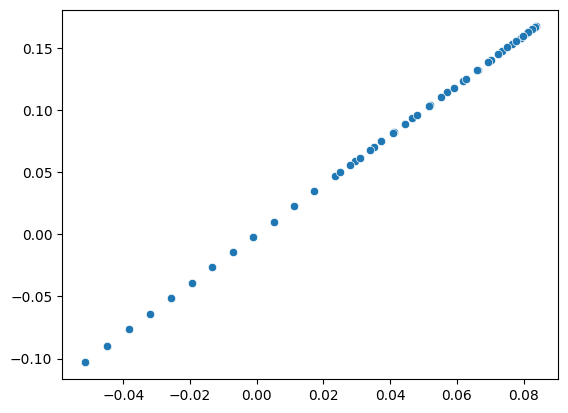

In [29]:
sigma = torch.linspace(0.01, 0.3, 100)

xi = torch.linspace(-0.1, 0.5, 50, device = "cuda")
X = torch.ones(10, 2, device="cuda")/3

M_val = torch.stack([DR.construct_M_from_basis(mollified_nonneg_simplex_core, x*torch.ones(10, 2, device="cuda"), 0.2).squeeze() for x in xi])

H_expm = torch.stack([hess_expm(0, 0.2, X = x*torch.ones(10, 2, device="cuda")) for x in xi])

sns.scatterplot(x = M_val.cpu().numpy(), y = H_expm.cpu().numpy())

In [ ]:
# Define range of theta
theta = torch.linspace(-2, 2, 2000)

# Rotation-based
fns_rotation = {
    'loss': loss_wrt_theta,
    'jacobian': lambda t: jacobian(loss_wrt_theta, t),
    'hessian': lambda t: hessian(loss_wrt_theta, t)
}
results_rotation = apply_all(fns_rotation, theta)

# Expm-based
fns_expm = {
    'loss': loss_wrt_theta_expm,
    'jacobian': lambda t: jacobian(loss_wrt_theta_expm, t),
    'hessian': lambda t: hessian(loss_wrt_theta_expm, t)
}
results_expm = apply_all(fns_expm, theta)

# Manual (expm) with custom gradient/Hessian
fns_manual = {
    'loss': loss_wrt_theta_expm,  # same as expm loss
    'jacobian': grad_expm,
    'hessian': hess_expm
}
results_manual = apply_all(fns_manual, theta)


**Plots:** Loss function using *rotation matrix, $\theta$,*  vs. using *geodesic curve $V(\epsilon)$*. First, second derivative computed using autograd vs. manual

**Expectation**: plots should be the same.

**Reality**: plots are the same.

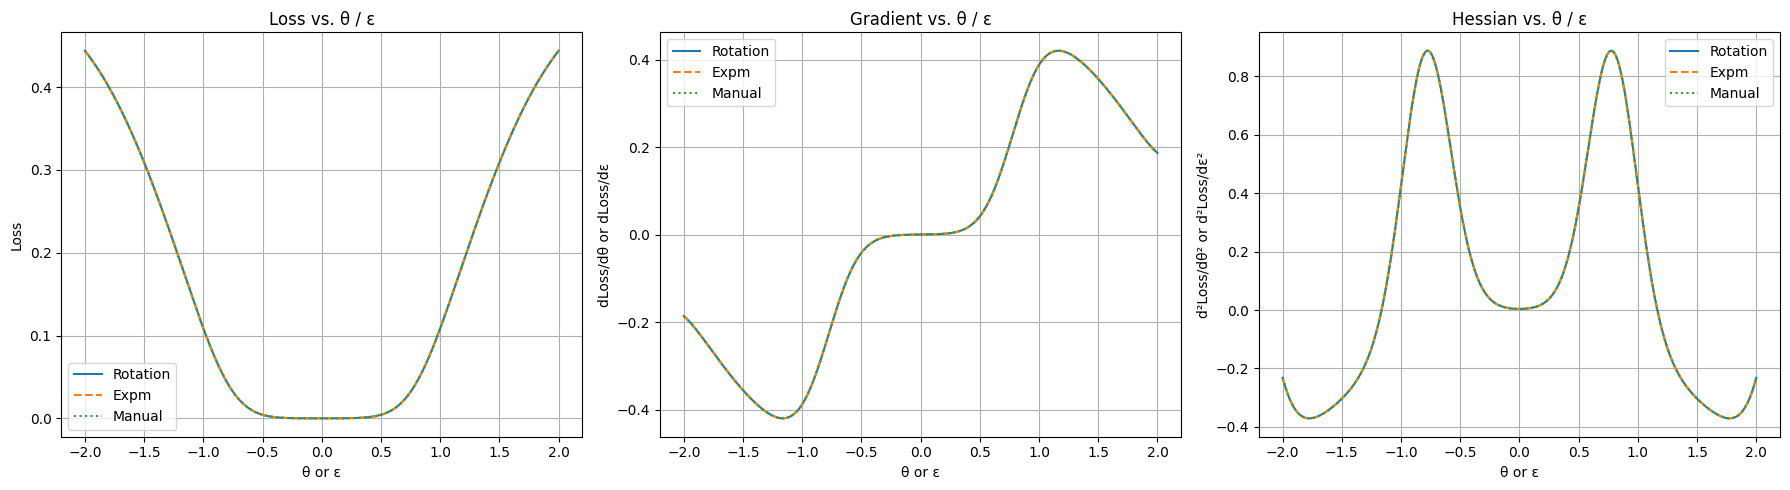

In [57]:
# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

theta_np = theta.cpu().numpy()  # shared x-axis values

# Plot 1: Loss
sns.lineplot(x=theta_np, y=results_rotation['loss'].cpu().numpy(), ax=axes[0], label="Rotation", linestyle="-")
sns.lineplot(x=theta_np, y=results_expm['loss'].cpu().numpy(), ax=axes[0], label="Expm", linestyle="--")
sns.lineplot(x=theta_np, y=results_manual['loss'].cpu().numpy(), ax=axes[0], label="Manual", linestyle=":")
axes[0].set_title("Loss vs. θ / ε")
axes[0].set_xlabel("θ or ε")
axes[0].set_ylabel("Loss")

# Plot 2: First derivative
sns.lineplot(x=theta_np, y=results_rotation['jacobian'].cpu().numpy(), ax=axes[1], label="Rotation", linestyle="-")
sns.lineplot(x=theta_np, y=results_expm['jacobian'].cpu().numpy(), ax=axes[1], label="Expm", linestyle="--")
sns.lineplot(x=theta_np, y=results_manual['jacobian'].cpu().numpy(), ax=axes[1], label="Manual", linestyle=":")
axes[1].set_title("Gradient vs. θ / ε")
axes[1].set_xlabel("θ or ε")
axes[1].set_ylabel("dLoss/dθ or dLoss/dε")

# Plot 3: Second derivative
sns.lineplot(x=theta_np, y=results_rotation['hessian'].cpu().numpy(), ax=axes[2], label="Rotation", linestyle="-")
sns.lineplot(x=theta_np, y=results_expm['hessian'].cpu().numpy(), ax=axes[2], label="Expm", linestyle="--")
sns.lineplot(x=theta_np, y=results_manual['hessian'].cpu().numpy(), ax=axes[2], label="Manual", linestyle=":")
axes[2].set_title("Hessian vs. θ / ε")
axes[2].set_xlabel("θ or ε")
axes[2].set_ylabel("d²Loss/dθ² or d²Loss/dε²")

# Add legends and grids
for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Monte Carlo Simulation for $ T_2 $

We simulate the quantity

$T_2 = \frac{\sigma}{\sqrt{2}} \phi\left( \frac{y_1}{\sqrt{2}\sigma} \right) + \mathbb{E}\left[ \epsilon_2 \Phi\left( -\frac{y_2 + \epsilon_2}{\sqrt{2}\sigma} \right) \right]$

where:
- $\epsilon_2 \sim \mathcal{N}(0, \sigma^2)$,
- $\phi$ and $\Phi$ are the standard normal PDF and CDF respectively.

The simulation steps are:

1. Draw samples $\epsilon_2^{(i)} \sim \mathcal{N}(0, \sigma^2)$ for $i = 1, \dotsc, n$.
2. For each $y \in [0,1]$, compute:
   - The deterministic term $\frac{\sigma}{\sqrt{2}} \phi\left( \frac{y_1}{\sqrt{2}\sigma} \right)$,
   - The Monte Carlo approximation of $\mathbb{E}\left[ \epsilon_2 \Phi\left( -\frac{y_2 + \epsilon_2}{\sqrt{2}\sigma} \right) \right]$ by averaging $\epsilon_2^{(i)} \Phi\left( -\frac{y_2 + \epsilon_2^{(i)}}{\sqrt{2}\sigma} \right)$ over the samples.
3. Add the two terms together to obtain $T_2$ at each $(y)$.
4. Plot $T_2$ as a function of $y$ if needed.

The standard normal PDF and CDF are implemented using `torch.distributions.Normal`, specifically:
- `normal.log_prob(z)` for $\log \phi(z)$,
- `normal.cdf(z)` for $\Phi(z)$.

We use $n = 100,000$ Monte Carlo samples to achieve an accurate approximation.


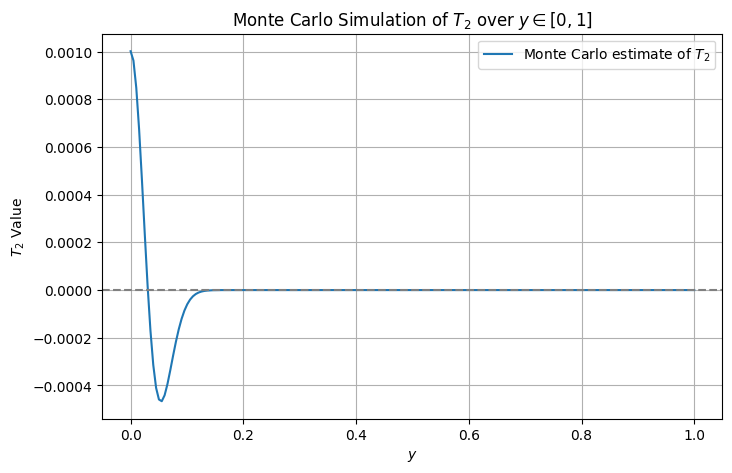

In [27]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(0)

# Define parameters
sigma = 0.02
n_samples = 100_000  # number of Monte Carlo samples
y_vals = torch.linspace(0, 1, 200)

# Create standard normal distribution
normal = Normal(0, 1)
log_phi = normal.log_prob
Phi = normal.cdf

# Simulate epsilon2 ~ N(0, sigma^2)
epsilon2_samples = torch.randn(n_samples) * sigma

# Allocate results
T2_estimates = []

# Loop over y values (same y used for y1 and y2)
for y in y_vals:
    sqrt2 = torch.sqrt(torch.tensor(2.0))
    
    # First term: sigma/sqrt(2) * phi(y / (sqrt(2)*sigma))
    first_term = (sigma / sqrt2) * torch.exp(log_phi(y / (sqrt2 * sigma)))
    
    # Second term: Monte Carlo estimate of epsilon2 * Phi(-(y + epsilon2) / (sqrt(2)*sigma))
    second_term_samples = epsilon2_samples * Phi(-(y + epsilon2_samples) / (sqrt2 * sigma))
    second_term = second_term_samples.mean()

    # Total T2
    T2 = first_term + second_term
    T2_estimates.append(T2.item())

# Convert to tensor
T2_estimates = torch.tensor(T2_estimates)

# Plotting
plt.figure(figsize=(8,5))
plt.plot(y_vals.numpy(), T2_estimates.numpy(), label=r"Monte Carlo estimate of $T_2$")
plt.axhline(0, color='gray', linestyle='--')
plt.title(r"Monte Carlo Simulation of $T_2$ over $y \in [0,1]$")
plt.xlabel(r"$y$")
plt.ylabel(r"$T_2$ Value")
plt.legend()
plt.grid(True)
plt.show()
